In [1]:
import pandas as pd
import allel
import intake
import fsspec
import zarr

In [2]:
cat = intake.open_catalog('https://malariagen.github.io/intake/gcs.yml')

In [3]:
df_signals = pd.read_csv('https://raw.githubusercontent.com/malariagen/agam-selection-atlas/0.1-alpha3/docs/_static/data/signals.csv')
df_signals

,uid,pop_key,focal_population,focal_population_label,reference_population,reference_population_label,statistic,chromosome,rank,epicenter,...,peak_end_seqid,peak_end_coord,delta_aic,delta_aic_left,delta_aic_right,min_flank_delta_aic,max_value,max_percentile,overlapping_genes,known_loci
0,XPEHH/BFS.UGS/2/1,BFS.UGS,BFS,Burkina Faso *An. gambiae*,UGS,Uganda *An. gambiae*,XPEHH,2,1,90080000,...,2L,29076217,1933.494873,774.387634,1367.388794,774.387634,5.912409,0.991532,AGAP006212 AGAP028453 AGAP006214 AGAP006215 AG...,NaN
1,H12/BFM/2/1,BFM,BFM,Burkina Faso *An. coluzzii*,NaN,NaN,H12,2,1,64400000,...,2L,3120000,1800.369141,1086.860107,619.791260,619.791260,0.888259,0.999420,AGAP004709 AGAP004710 AGAP004711 AGAP004712 AG...,Vgsc
2,H12/BFS/2/1,BFS,BFS,Burkina Faso *An. gambiae*,NaN,NaN,H12,2,1,63600000,...,2L,3640000,1776.373657,946.727356,857.772461,857.772461,1.000000,0.999955,AGAP004693 AGAP004694 AGAP028434 AGAP028435 AG...,Vgsc
3,H12/GNS/2/1,GNS,GNS,Guinea *An. gambiae*,NaN,NaN,H12,2,1,63400000,...,2L,3540000,1685.437012,869.198914,832.084656,832.084656,1.000000,0.999822,AGAP004691 AGAP028433 AGAP004692 AGAP004693 AG...,Vgsc
4,IHS/UGS/2/1,UGS,UGS,Uganda *An. gambiae*,NaN,NaN,IHS,2,1,28460000,...,2R,29988392,1661.858643,791.465454,887.227173,791.465454,6.683009,0.999789,AGAP002846 AGAP013388 AGAP002847 AGAP002848 AG...,Cyp6p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,XPEHH/AOM.GWA/2/6,AOM.GWA,AOM,Angola *An. coluzzii*,GWA,Guinea Bissau,XPEHH,2,6,86820000,...,2L,26808010,92.645866,34.062840,56.219551,34.062840,3.102347,0.839457,AGAP006027 AGAP006028,Rdl
285,IHS/GAS/3/2,GAS,GAS,Gabon *An. gambiae*,NaN,NaN,IHS,3,2,63660000,...,3L,13993871,92.540459,31.293573,65.061882,31.293573,4.206303,0.966653,AGAP010790 AGAP010791 AGAP010792 AGAP010793 AG...,NaN
286,XPEHH/UGS.CMS/2/4,UGS.CMS,UGS,Uganda *An. gambiae*,CMS,Cameroon *An. gambiae*,XPEHH,2,4,75960000,...,2L,14737533,92.198570,53.579063,48.301678,48.301678,4.222619,0.914326,AGAP005347 AGAP005348 AGAP005349 AGAP005350 AG...,NaN
287,XPEHH/AOM.GWA/2/7,AOM.GWA,AOM,Angola *An. coluzzii*,GWA,Guinea Bissau,XPEHH,2,7,28500000,...,2R,28589516,92.075150,66.062965,49.596020,49.596020,3.108269,0.840829,AGAP002859 AGAP002862 AGAP013128 AGAP002863 AG...,Cyp6p


In [4]:
df_signals.columns

Index(['uid', 'pop_key', 'focal_population', 'focal_population_label',
       'reference_population', 'reference_population_label', 'statistic',
       'chromosome', 'rank', 'epicenter', 'epicenter_seqid', 'epicenter_coord',
       'focus_start', 'focus_start_seqid', 'focus_start_coord', 'focus_end',
       'focus_end_seqid', 'focus_end_coord', 'peak_start', 'peak_start_seqid',
       'peak_start_coord', 'peak_end', 'peak_end_seqid', 'peak_end_coord',
       'delta_aic', 'delta_aic_left', 'delta_aic_right', 'min_flank_delta_aic',
       'max_value', 'max_percentile', 'overlapping_genes', 'known_loci'],
      dtype='object')

In [5]:
callset_snps = cat.ag1.snps.to_zarr()
df_samples = cat.ag1.samples.read() 
pop_locs = {
    p: df_samples[df_samples.population == p].index.values
    for p in df_samples.population.unique()
}

/home/aliman/malariagen/binder/conda/envs/dphil-v2.5.1/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Sensitivity

In [6]:
def get_afs(c, p):

    pos = allel.SortedIndex(callset_snps[c]['variants/POS'])
    loc = pos.locate_key(p)
    gt = allel.GenotypeArray(callset_snps[c]['calldata/GT'][loc][None, :, :])
    acs = gt.count_alleles_subpops(pop_locs)
    afs = [
        {'pop': p, 'af': acs[p].to_frequencies()[0, 1]}
        for p in df_samples.population.unique()
    ]
    df = pd.DataFrame.from_records(afs, index='pop')
    return df

In [7]:
gste2_i114t = '3R', 28_598_166

In [8]:
get_afs(*gste2_i114t)

,af
pop,
BFS,0.074074
BFM,0.514493
UGS,0.000000
GWA,0.000000
KES,0.000000
CMS,0.007273
AOM,0.008333
GAS,0.303571
GNS,0.129032


In [9]:
gste2_truth = 'BFS', 'BFM', 'GAS', 'GNS'

In [10]:
vgsc_l995s = '2L', 2_422_651

In [11]:
get_afs(*vgsc_l995s)

,af
pop,
BFS,0.000000
BFM,0.000000
UGS,1.000000
GWA,0.000000
KES,0.761364
CMS,0.154545
AOM,0.000000
GAS,0.642857
GNS,0.000000


In [12]:
vgsc_l995f = '2L', 2_422_652

In [13]:
get_afs(*vgsc_l995f)

,af
pop,
BFS,1.000000
BFM,0.847826
UGS,0.000000
GWA,0.000000
KES,0.000000
CMS,0.529091
AOM,0.858333
GAS,0.357143
GNS,1.000000


In [14]:
vgsc_truth = 'BFS', 'BFM', 'UGS', 'CMS', 'AOM', 'GAS', 'GNS'

In [15]:
gaba_a296s = '2L', 25_429_235

In [16]:
get_afs(*gaba_a296s)

,af
pop,
BFS,0.000000
BFM,0.615942
UGS,0.000000
GWA,0.000000
KES,0.000000
CMS,0.000000
AOM,0.000000
GAS,0.000000
GNS,0.000000


In [17]:
gaba_a296g = '2L', 25_429_236

In [18]:
get_afs(*gaba_a296g)

,af
pop,
BFS,0.413580
BFM,0.000000
UGS,0.000000
GWA,0.000000
KES,0.000000
CMS,0.301818
AOM,0.441667
GAS,0.812500
GNS,0.354839


In [19]:
gaba_truth = 'BFM', 'BFS', 'CMS', 'AOM', 'GAS', 'GNS'

In [20]:
ace1_g280s = '2R', 3_492_074

In [21]:
get_afs(*ace1_g280s)

,af
pop,
BFS,0.172840
BFM,0.021739
UGS,0.000000
GWA,0.000000
KES,0.000000
CMS,0.000000
AOM,0.000000
GAS,0.000000
GNS,0.129032


In [22]:
ace1_truth = 'BFS', 'GNS'

In [23]:
df_signals

,uid,pop_key,focal_population,focal_population_label,reference_population,reference_population_label,statistic,chromosome,rank,epicenter,...,peak_end_seqid,peak_end_coord,delta_aic,delta_aic_left,delta_aic_right,min_flank_delta_aic,max_value,max_percentile,overlapping_genes,known_loci
0,XPEHH/BFS.UGS/2/1,BFS.UGS,BFS,Burkina Faso *An. gambiae*,UGS,Uganda *An. gambiae*,XPEHH,2,1,90080000,...,2L,29076217,1933.494873,774.387634,1367.388794,774.387634,5.912409,0.991532,AGAP006212 AGAP028453 AGAP006214 AGAP006215 AG...,NaN
1,H12/BFM/2/1,BFM,BFM,Burkina Faso *An. coluzzii*,NaN,NaN,H12,2,1,64400000,...,2L,3120000,1800.369141,1086.860107,619.791260,619.791260,0.888259,0.999420,AGAP004709 AGAP004710 AGAP004711 AGAP004712 AG...,Vgsc
2,H12/BFS/2/1,BFS,BFS,Burkina Faso *An. gambiae*,NaN,NaN,H12,2,1,63600000,...,2L,3640000,1776.373657,946.727356,857.772461,857.772461,1.000000,0.999955,AGAP004693 AGAP004694 AGAP028434 AGAP028435 AG...,Vgsc
3,H12/GNS/2/1,GNS,GNS,Guinea *An. gambiae*,NaN,NaN,H12,2,1,63400000,...,2L,3540000,1685.437012,869.198914,832.084656,832.084656,1.000000,0.999822,AGAP004691 AGAP028433 AGAP004692 AGAP004693 AG...,Vgsc
4,IHS/UGS/2/1,UGS,UGS,Uganda *An. gambiae*,NaN,NaN,IHS,2,1,28460000,...,2R,29988392,1661.858643,791.465454,887.227173,791.465454,6.683009,0.999789,AGAP002846 AGAP013388 AGAP002847 AGAP002848 AG...,Cyp6p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,XPEHH/AOM.GWA/2/6,AOM.GWA,AOM,Angola *An. coluzzii*,GWA,Guinea Bissau,XPEHH,2,6,86820000,...,2L,26808010,92.645866,34.062840,56.219551,34.062840,3.102347,0.839457,AGAP006027 AGAP006028,Rdl
285,IHS/GAS/3/2,GAS,GAS,Gabon *An. gambiae*,NaN,NaN,IHS,3,2,63660000,...,3L,13993871,92.540459,31.293573,65.061882,31.293573,4.206303,0.966653,AGAP010790 AGAP010791 AGAP010792 AGAP010793 AG...,NaN
286,XPEHH/UGS.CMS/2/4,UGS.CMS,UGS,Uganda *An. gambiae*,CMS,Cameroon *An. gambiae*,XPEHH,2,4,75960000,...,2L,14737533,92.198570,53.579063,48.301678,48.301678,4.222619,0.914326,AGAP005347 AGAP005348 AGAP005349 AGAP005350 AG...,NaN
287,XPEHH/AOM.GWA/2/7,AOM.GWA,AOM,Angola *An. coluzzii*,GWA,Guinea Bissau,XPEHH,2,7,28500000,...,2R,28589516,92.075150,66.062965,49.596020,49.596020,3.108269,0.840829,AGAP002859 AGAP002862 AGAP013128 AGAP002863 AG...,Cyp6p


In [24]:
df_signals.columns

Index(['uid', 'pop_key', 'focal_population', 'focal_population_label',
       'reference_population', 'reference_population_label', 'statistic',
       'chromosome', 'rank', 'epicenter', 'epicenter_seqid', 'epicenter_coord',
       'focus_start', 'focus_start_seqid', 'focus_start_coord', 'focus_end',
       'focus_end_seqid', 'focus_end_coord', 'peak_start', 'peak_start_seqid',
       'peak_start_coord', 'peak_end', 'peak_end_seqid', 'peak_end_coord',
       'delta_aic', 'delta_aic_left', 'delta_aic_right', 'min_flank_delta_aic',
       'max_value', 'max_percentile', 'overlapping_genes', 'known_loci'],
      dtype='object')

In [25]:
list(cat)

['ag1', 'ag2', 'ag3', 'ag3_1']

In [26]:
store = fsspec.get_mapper('gs://vo_agam_release/reference/genome/agamp4/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.zarr')
genome = zarr.open_consolidated(store)
genome

<zarr.hierarchy.Group '/'>

In [27]:
def analyse_sensitivity(locus, truth_pops):
    c, p = locus
    if c[0] in '23':
        chromosome = c[0]
        if c[1] == 'L':
            position = p + genome[f"{chromosome}R"].shape[0]
        else:
            position = p
    else:
        chromosome, position = c, p
    signals = df_signals[(df_signals.chromosome == chromosome) & 
                         (df_signals.peak_start <= position) & 
                         (df_signals.peak_end >= position)]

    truth_pops = set(truth_pops)
    n_true = len(truth_pops)
    results = []
    all_positive_pops = set()
    for stat in 'H12', 'XPEHH', 'IHS':
        positive_pops = set(signals[signals.statistic == stat].focal_population.values)
        all_positive_pops |= positive_pops
        n_positive = len(positive_pops)
        n_true_positive = len(positive_pops.intersection(truth_pops))
        sens = n_true_positive * 100 / n_true
        results.append({'stat': stat, 
                        'n_true': n_true, 
                        'n_positive': n_positive,
                        'n_true_positive': n_true_positive, 
                        'sensitivity': sens})
    all_n_positive = len(all_positive_pops)
    all_n_true_positive = len(all_positive_pops.intersection(truth_pops))
    all_sens = all_n_true_positive * 100 / n_true
    results.append({'stat': 'all', 
                    'n_true': n_true, 
                    'n_positive': all_n_positive,
                    'n_true_positive': all_n_true_positive, 
                    'sensitivity': all_sens})
    df_results = pd.DataFrame.from_records(results)
    return df_results

In [28]:
df_vgsc_sens = analyse_sensitivity(vgsc_l995f, vgsc_truth)
df_vgsc_sens.insert(0, 'gene', 'Vgsc')
df_gaba_sens = analyse_sensitivity(gaba_a296g, gaba_truth)
df_gaba_sens.insert(0, 'gene', 'Gaba')
df_ace1_sens = analyse_sensitivity(ace1_g280s, ace1_truth)
df_ace1_sens.insert(0, 'gene', 'Ace1')
df_gste2_sens = analyse_sensitivity(gste2_i114t, gste2_truth)
df_gste2_sens.insert(0, 'gene', 'Gste2')
df_sens = (
    pd.concat([
        df_vgsc_sens, df_gaba_sens, df_ace1_sens, df_gste2_sens
    ])
    .reset_index(drop=True)
)
df_sens

,gene,stat,n_true,n_positive,n_true_positive,sensitivity
0,Vgsc,H12,7,7,7,100.000000
1,Vgsc,XPEHH,7,6,6,85.714286
2,Vgsc,IHS,7,0,0,0.000000
3,Vgsc,all,7,7,7,100.000000
4,Gaba,H12,6,5,5,83.333333
5,Gaba,XPEHH,6,5,5,83.333333
6,Gaba,IHS,6,2,2,33.333333
7,Gaba,all,6,6,6,100.000000
8,Ace1,H12,2,0,0,0.000000
9,Ace1,XPEHH,2,1,1,50.000000


In [29]:
df_all_sens = (
    df_sens
    .groupby('stat')
    .aggregate({'n_true': sum, 'n_positive': sum, 'n_true_positive': sum})
    .reset_index(drop=False)
)
df_all_sens['sensitivity'] = df_all_sens.n_true_positive * 100 / df_all_sens.n_true
df_all_sens.insert(0, 'gene', 'all')
df_all_sens = pd.concat([df_sens, df_all_sens]).reset_index(drop=True)
df_all_sens

,gene,stat,n_true,n_positive,n_true_positive,sensitivity
0,Vgsc,H12,7,7,7,100.000000
1,Vgsc,XPEHH,7,6,6,85.714286
2,Vgsc,IHS,7,0,0,0.000000
3,Vgsc,all,7,7,7,100.000000
4,Gaba,H12,6,5,5,83.333333
5,Gaba,XPEHH,6,5,5,83.333333
6,Gaba,IHS,6,2,2,33.333333
7,Gaba,all,6,6,6,100.000000
8,Ace1,H12,2,0,0,0.000000
9,Ace1,XPEHH,2,1,1,50.000000


In [30]:
with open('tbl_sens.tex', mode='w') as f:
    df_all_sens.to_latex(
        f,
        index=False, 
        header=['Gene', 'Statistic', 'No. true', 'No. positive', 'No. true positive', 'Sensitivity (\\%)'],
        formatters={
            'gene': lambda v: v if v == 'all' else '\\textit{{{}}}'.format(v),
            'sensitivity': lambda v: '{:.0f}'.format(v)},
        escape=False,
    )

## Mapping accuracy

In [31]:
df_signals

,uid,pop_key,focal_population,focal_population_label,reference_population,reference_population_label,statistic,chromosome,rank,epicenter,...,peak_end_seqid,peak_end_coord,delta_aic,delta_aic_left,delta_aic_right,min_flank_delta_aic,max_value,max_percentile,overlapping_genes,known_loci
0,XPEHH/BFS.UGS/2/1,BFS.UGS,BFS,Burkina Faso *An. gambiae*,UGS,Uganda *An. gambiae*,XPEHH,2,1,90080000,...,2L,29076217,1933.494873,774.387634,1367.388794,774.387634,5.912409,0.991532,AGAP006212 AGAP028453 AGAP006214 AGAP006215 AG...,NaN
1,H12/BFM/2/1,BFM,BFM,Burkina Faso *An. coluzzii*,NaN,NaN,H12,2,1,64400000,...,2L,3120000,1800.369141,1086.860107,619.791260,619.791260,0.888259,0.999420,AGAP004709 AGAP004710 AGAP004711 AGAP004712 AG...,Vgsc
2,H12/BFS/2/1,BFS,BFS,Burkina Faso *An. gambiae*,NaN,NaN,H12,2,1,63600000,...,2L,3640000,1776.373657,946.727356,857.772461,857.772461,1.000000,0.999955,AGAP004693 AGAP004694 AGAP028434 AGAP028435 AG...,Vgsc
3,H12/GNS/2/1,GNS,GNS,Guinea *An. gambiae*,NaN,NaN,H12,2,1,63400000,...,2L,3540000,1685.437012,869.198914,832.084656,832.084656,1.000000,0.999822,AGAP004691 AGAP028433 AGAP004692 AGAP004693 AG...,Vgsc
4,IHS/UGS/2/1,UGS,UGS,Uganda *An. gambiae*,NaN,NaN,IHS,2,1,28460000,...,2R,29988392,1661.858643,791.465454,887.227173,791.465454,6.683009,0.999789,AGAP002846 AGAP013388 AGAP002847 AGAP002848 AG...,Cyp6p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,XPEHH/AOM.GWA/2/6,AOM.GWA,AOM,Angola *An. coluzzii*,GWA,Guinea Bissau,XPEHH,2,6,86820000,...,2L,26808010,92.645866,34.062840,56.219551,34.062840,3.102347,0.839457,AGAP006027 AGAP006028,Rdl
285,IHS/GAS/3/2,GAS,GAS,Gabon *An. gambiae*,NaN,NaN,IHS,3,2,63660000,...,3L,13993871,92.540459,31.293573,65.061882,31.293573,4.206303,0.966653,AGAP010790 AGAP010791 AGAP010792 AGAP010793 AG...,NaN
286,XPEHH/UGS.CMS/2/4,UGS.CMS,UGS,Uganda *An. gambiae*,CMS,Cameroon *An. gambiae*,XPEHH,2,4,75960000,...,2L,14737533,92.198570,53.579063,48.301678,48.301678,4.222619,0.914326,AGAP005347 AGAP005348 AGAP005349 AGAP005350 AG...,NaN
287,XPEHH/AOM.GWA/2/7,AOM.GWA,AOM,Angola *An. coluzzii*,GWA,Guinea Bissau,XPEHH,2,7,28500000,...,2R,28589516,92.075150,66.062965,49.596020,49.596020,3.108269,0.840829,AGAP002859 AGAP002862 AGAP013128 AGAP002863 AG...,Cyp6p


In [32]:
import numpy as np

In [33]:
def analyse_accuracy(locus):
    c, p = locus
    if c[0] in '23':
        chromosome = c[0]
        if c[1] == 'L':
            position = p + genome[f"{chromosome}R"].shape[0]
        else:
            position = p
    else:
        chromosome, position = c, p
    signals = df_signals[(df_signals.chromosome == chromosome) & 
                         (df_signals.peak_start <= position) & 
                         (df_signals.peak_end >= position)].copy()
    signals['mapping_error'] = np.fabs(signals['epicenter'] - position) / 1e3
    signals['ci'] = (signals.focus_end - signals.focus_start) / 1e3
    signals['within_ci'] = (signals.focus_start <= position) & (signals.focus_end >= position)
    signals['within_ci_plus50k'] = ((signals.focus_start - 50_000) <= position) & ((signals.focus_end + 50_000) >= position)
    
    return signals[['focal_population', 'statistic', 'mapping_error', 'ci', 'within_ci', 'within_ci_plus50k']]

    

In [34]:
cyp6p3 = '2R', (28_491_415 + 28_493_141) / 2
cyp9k1 = 'X', (15_240_572 + 15_242_864) / 2

In [35]:
df_acc_gste2 = analyse_accuracy(gste2_i114t)
df_acc_gste2.insert(0, 'gene', 'Gste2')
df_acc_ace1 = analyse_accuracy(ace1_g280s)
df_acc_ace1.insert(0, 'gene', 'Ace1')
df_acc_gaba = analyse_accuracy(gaba_a296g)
df_acc_gaba.insert(0, 'gene', 'Gaba')
df_acc_vgsc = analyse_accuracy(vgsc_l995f)
df_acc_vgsc.insert(0, 'gene', 'Vgsc')
df_acc_cyp6p3 = analyse_accuracy(cyp6p3)
df_acc_cyp6p3.insert(0, 'gene', 'Cyp6p3')
df_acc_cyp9k1 = analyse_accuracy(cyp9k1)
df_acc_cyp9k1.insert(0, 'gene', 'Cyp9k1')


df_acc = pd.concat([df_acc_gste2, 
                    df_acc_ace1, 
                    df_acc_gaba, 
                    df_acc_vgsc,
                    df_acc_cyp6p3,
                    df_acc_cyp9k1])
df_acc

,gene,focal_population,statistic,mapping_error,ci,within_ci,within_ci_plus50k
6,Gste2,CMS,H12,1.834,40.0,True,True
8,Gste2,CMS,XPEHH,41.834,100.0,False,True
11,Gste2,CMS,XPEHH,298.166,140.0,False,False
12,Gste2,BFS,XPEHH,258.166,40.0,False,False
14,Gste2,BFS,XPEHH,38.166,120.0,True,True
...,...,...,...,...,...,...,...
151,Cyp9k1,GAS,XPEHH,1001.718,360.0,False,False
154,Cyp9k1,AOM,H12,661.718,100.0,False,False
155,Cyp9k1,GAS,H12,941.718,520.0,False,False
164,Cyp9k1,AOM,XPEHH,161.718,680.0,False,False


In [36]:
df_acc_agg_gene = (
    df_acc
    .groupby(['gene', 'statistic'])
    .aggregate({'mapping_error': (len, 
                                  lambda v: np.percentile(v, 25), 
                                  lambda v: np.percentile(v, 50), 
                                  lambda v: np.percentile(v, 75)),
                'within_ci': lambda v: np.count_nonzero(v) * 100 / len(v),
                'within_ci_plus50k': lambda v: np.count_nonzero(v) * 100 / len(v),
               
               })
    .reset_index(drop=False)
)
df_acc_agg_gene

gene statistic mapping_error                                   \
                               len <lambda_0> <lambda_1> <lambda_2>   
0     Ace1       IHS           2.0   243.9630    280.000   316.0370   
1     Ace1     XPEHH           1.0    92.0740     92.074    92.0740   
2   Cyp6p3       H12           7.0    12.2780     32.278    42.2780   
3   Cyp6p3       IHS           6.0    77.2780    100.000   347.7220   
4   Cyp6p3     XPEHH           8.0    31.1390     42.278   173.8610   
5   Cyp9k1       H12           6.0    80.8590    210.000   551.7180   
6   Cyp9k1       IHS           4.0   224.1410    320.000   391.7180   
7   Cyp9k1     XPEHH          10.0   139.1410    161.718   394.1410   
8     Gaba       H12           5.0    45.6590     45.659   174.3410   
9     Gaba       IHS           2.0   197.8295    270.000   342.1705   
10    Gaba     XPEHH           8.0    25.6590     85.659   132.8295   
11   Gste2       H12           5.0     1.8340     18.166    58.1660   
12   Gste2       IHS           5.0    78.1660    258.166   278.1660   
13   Gste2     XPEHH          10.0    25.9170     41.834   243.1660   
14    Vgsc       H12           7.0   422.2430    472.243   620.0000   
15    Vgsc     XPEHH           8.0   757.2430   1162.243  4326.1215   

     within_ci within_ci_plus50k  
      <lambda>          <lambda>  
0    50.000000         50.000000  
1   100.000000        100.000000  
2    42.857143         85.714286  
3    66.666667         66.666667  
4    62.500000         62.500000  
5    33.333333         50.000000  
6    75.000000         75.000000  
7    30.000000         40.000000  
8     0.000000         60.000000  
9    50.000000        100.000000  
10   12.500000         87.500000  
11   60.000000         80.000000  
12   60.000000         60.000000  
13   30.000000         60.000000  
14   42.857143         42.857143  
15   25.000000         25.000000

In [37]:
df_acc_agg = (
    df_acc
    .groupby(['statistic'])
    .aggregate({'mapping_error': (len, 
                                  lambda v: np.percentile(v, 25), 
                                  lambda v: np.percentile(v, 50), 
                                  lambda v: np.percentile(v, 75)),
                'within_ci': lambda v: np.count_nonzero(v) * 100 / len(v),
                'within_ci_plus50k': lambda v: np.count_nonzero(v) * 100 / len(v),
               
               })
    .reset_index(drop=False)
)
df_acc_agg.insert(0, 'gene', 'all')
df_acc_agg = pd.concat([df_acc_agg_gene, df_acc_agg])
df_acc_agg.columns = ['gene', 'statistic', 'n', 'err25', 'err50', 'err75', 'inci', 'inci50']
df_acc_agg

,gene,statistic,n,err25,err50,err75,inci,inci50
0,Ace1,IHS,2.0,243.9630,280.000,316.0370,50.000000,50.000000
1,Ace1,XPEHH,1.0,92.0740,92.074,92.0740,100.000000,100.000000
2,Cyp6p3,H12,7.0,12.2780,32.278,42.2780,42.857143,85.714286
3,Cyp6p3,IHS,6.0,77.2780,100.000,347.7220,66.666667,66.666667
4,Cyp6p3,XPEHH,8.0,31.1390,42.278,173.8610,62.500000,62.500000
5,Cyp9k1,H12,6.0,80.8590,210.000,551.7180,33.333333,50.000000
6,Cyp9k1,IHS,4.0,224.1410,320.000,391.7180,75.000000,75.000000
7,Cyp9k1,XPEHH,10.0,139.1410,161.718,394.1410,30.000000,40.000000
8,Gaba,H12,5.0,45.6590,45.659,174.3410,0.000000,60.000000
9,Gaba,IHS,2.0,197.8295,270.000,342.1705,50.000000,100.000000


In [38]:
with open('tbl_acc.tex', mode='w') as f:
    df_acc_agg.to_latex(
        f, 
        index=False,
        header=['Gene', 'Statistic', '$N$', '$ME_{25}$', '$ME_{50}$', '$ME_{75}$', 'Within CI (\\%)', 'Within CI + 50 kb (\\%)'],
        escape=False,
        formatters={
          'gene': lambda v: v if v == 'all' else '\\textit{{{}}}'.format(v),
          'n': lambda v: '{:.0f}'.format(v),
          'err25': lambda v: '{:.0f}'.format(v),
          'err50': lambda v: '{:.0f}'.format(v),
          'err75': lambda v: '{:.0f}'.format(v),
          'inci': lambda v: '{:.0f}'.format(v),
          'inci50': lambda v: '{:.0f}'.format(v),
         }
    )

In [39]:
df_acc

,gene,focal_population,statistic,mapping_error,ci,within_ci,within_ci_plus50k
6,Gste2,CMS,H12,1.834,40.0,True,True
8,Gste2,CMS,XPEHH,41.834,100.0,False,True
11,Gste2,CMS,XPEHH,298.166,140.0,False,False
12,Gste2,BFS,XPEHH,258.166,40.0,False,False
14,Gste2,BFS,XPEHH,38.166,120.0,True,True
...,...,...,...,...,...,...,...
151,Cyp9k1,GAS,XPEHH,1001.718,360.0,False,False
154,Cyp9k1,AOM,H12,661.718,100.0,False,False
155,Cyp9k1,GAS,H12,941.718,520.0,False,False
164,Cyp9k1,AOM,XPEHH,161.718,680.0,False,False


In [40]:

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import seaborn as sns

In [41]:
import scipy.stats

In [42]:
scipy.stats.pearsonr

<function scipy.stats.stats.pearsonr(x, y)>

In [43]:
def plot_ci_error(stat=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(facecolor='w', figsize=(3.5, 3.5))
    if stat is not None:
        df = df_acc[df_acc.statistic == stat]
    else:
        df = df_acc
    x = df.ci * 1e3
    y = df.mapping_error * 1e3
    lower = 0.5 * np.min([np.min(x), np.min(y)])
    upper = 2 * np.max([np.max(x), np.max(y)])
    ax.plot([lower, upper], [lower, upper], linestyle='--', marker=' ', color='k', lw=1)
#     c = np.array(['blue'] * len(x))
#     c[y > x] = 'red'
    ax.scatter(x, y)
    r, p = scipy.stats.pearsonr(x, y)
    ax.set_xlim(lower, upper)
    ax.set_ylim(lower, upper)
    ax.set_xlabel('Focus confidence interval (bp)')
    ax.set_ylabel('Mapping error (bp)')
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_title(stat)
    ax.text(0.05, 0.95, f'$r = {r:.2f}$', transform=ax.transAxes, ha='left', va='top')

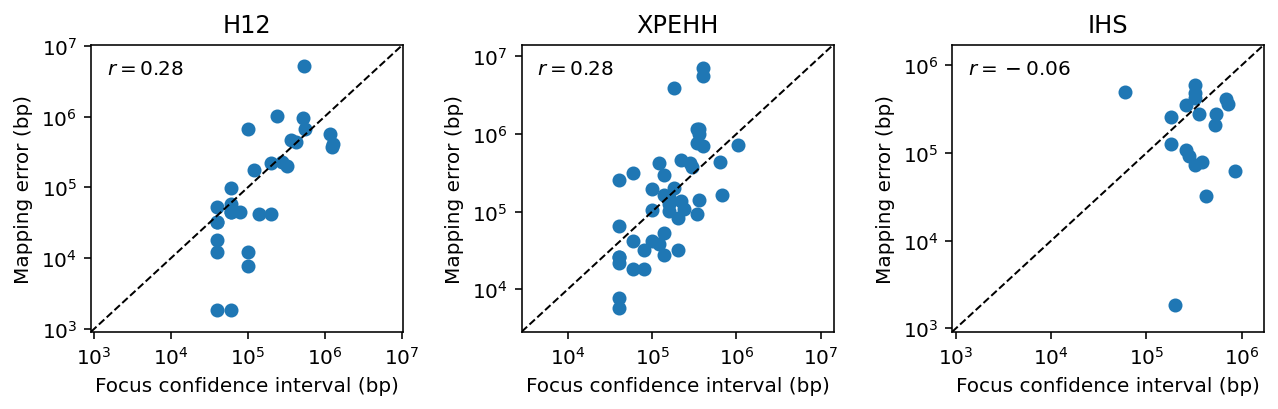

In [44]:
fig = plt.figure(figsize=(9, 3), facecolor='w')
ax = fig.add_subplot(1, 3, 1)
plot_ci_error('H12', ax)
ax = fig.add_subplot(1, 3, 2)
plot_ci_error('XPEHH', ax)
ax = fig.add_subplot(1, 3, 3)
plot_ci_error('IHS', ax)
fig.tight_layout()
fig.savefig('../artwork/chapter5/accuracy.pdf', bbox_inches='tight')

In [46]:
df_signals.columns

Index(['uid', 'pop_key', 'focal_population', 'focal_population_label',
       'reference_population', 'reference_population_label', 'statistic',
       'chromosome', 'rank', 'epicenter', 'epicenter_seqid', 'epicenter_coord',
       'focus_start', 'focus_start_seqid', 'focus_start_coord', 'focus_end',
       'focus_end_seqid', 'focus_end_coord', 'peak_start', 'peak_start_seqid',
       'peak_start_coord', 'peak_end', 'peak_end_seqid', 'peak_end_coord',
       'delta_aic', 'delta_aic_left', 'delta_aic_right', 'min_flank_delta_aic',
       'max_value', 'max_percentile', 'overlapping_genes', 'known_loci'],
      dtype='object')

In [48]:
df_signals.known_loci.unique()

array([nan, 'Vgsc', 'Cyp6p', 'Gste', 'Cyp9k1', 'Rdl', 'Ace1', 'Tep1'],
      dtype=object)

In [50]:
df_signals.known_loci.isna().sum()

229